In [1]:
# it is a good idea to use a GPU machine (e.g. L4) for this lab.
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.autograd import Function
import numpy as np
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import os
import requests

def download_from_url(url, filename, overwrite=False):
    if os.path.exists(filename) and not overwrite:
        return
        
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

## Objective

Consider input space $X$, labels $Y$. $D_S$ denotes the labelled source domain and $D_T$ denotes the unlabelled target domain.
\begin{align}
S = \{(x_i, y_i)\}_{i=1}^n \sim (D_S)^n, \quad T = \{x_i\}_{i=n+1}^N \sim (D_T)^{N-n}.
\end{align}

Our goal is build a classifier $f: X \rightarrow Y$ that can generalize from the labelled source domain to unlabelled target domain. More formally,

\begin{equation}
R_{D_T}(f) = \Pr_{(x,y)\sim D_T} (f(x) \neq y).
\end{equation}


### Part I: Inverted MNIST

The case we'll consider in this example is
$z \rightarrow x \rightarrow y$

In [2]:
def load_datasets():
    transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])
    target_transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor(), lambda x: 1 - x])

    source_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    indices = np.arange(len(source_dataset))
    np.random.shuffle(indices)
    split = int(len(indices) * 0.8)

    source_train = Subset(source_dataset, indices[:split])
    source_test = Subset(source_dataset, indices[split:])
    target_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=target_transform)
    target_train = Subset(target_dataset, indices[:split])
    target_test = Subset(target_dataset, indices[split:])

    return source_train, source_test, target_train, target_test

def get_dataloaders(source_train, source_test, target_train, target_test, batch_size=64):
    source_loader_train = DataLoader(source_train, batch_size=batch_size, shuffle=True)
    source_loader_test = DataLoader(source_test, batch_size=batch_size)
    target_loader_train = DataLoader(target_train, batch_size=batch_size, shuffle=True)
    target_loader_test = DataLoader(target_test, batch_size=batch_size)
    return source_loader_train, source_loader_test, target_loader_train, target_loader_test

### Domain adversarial learning


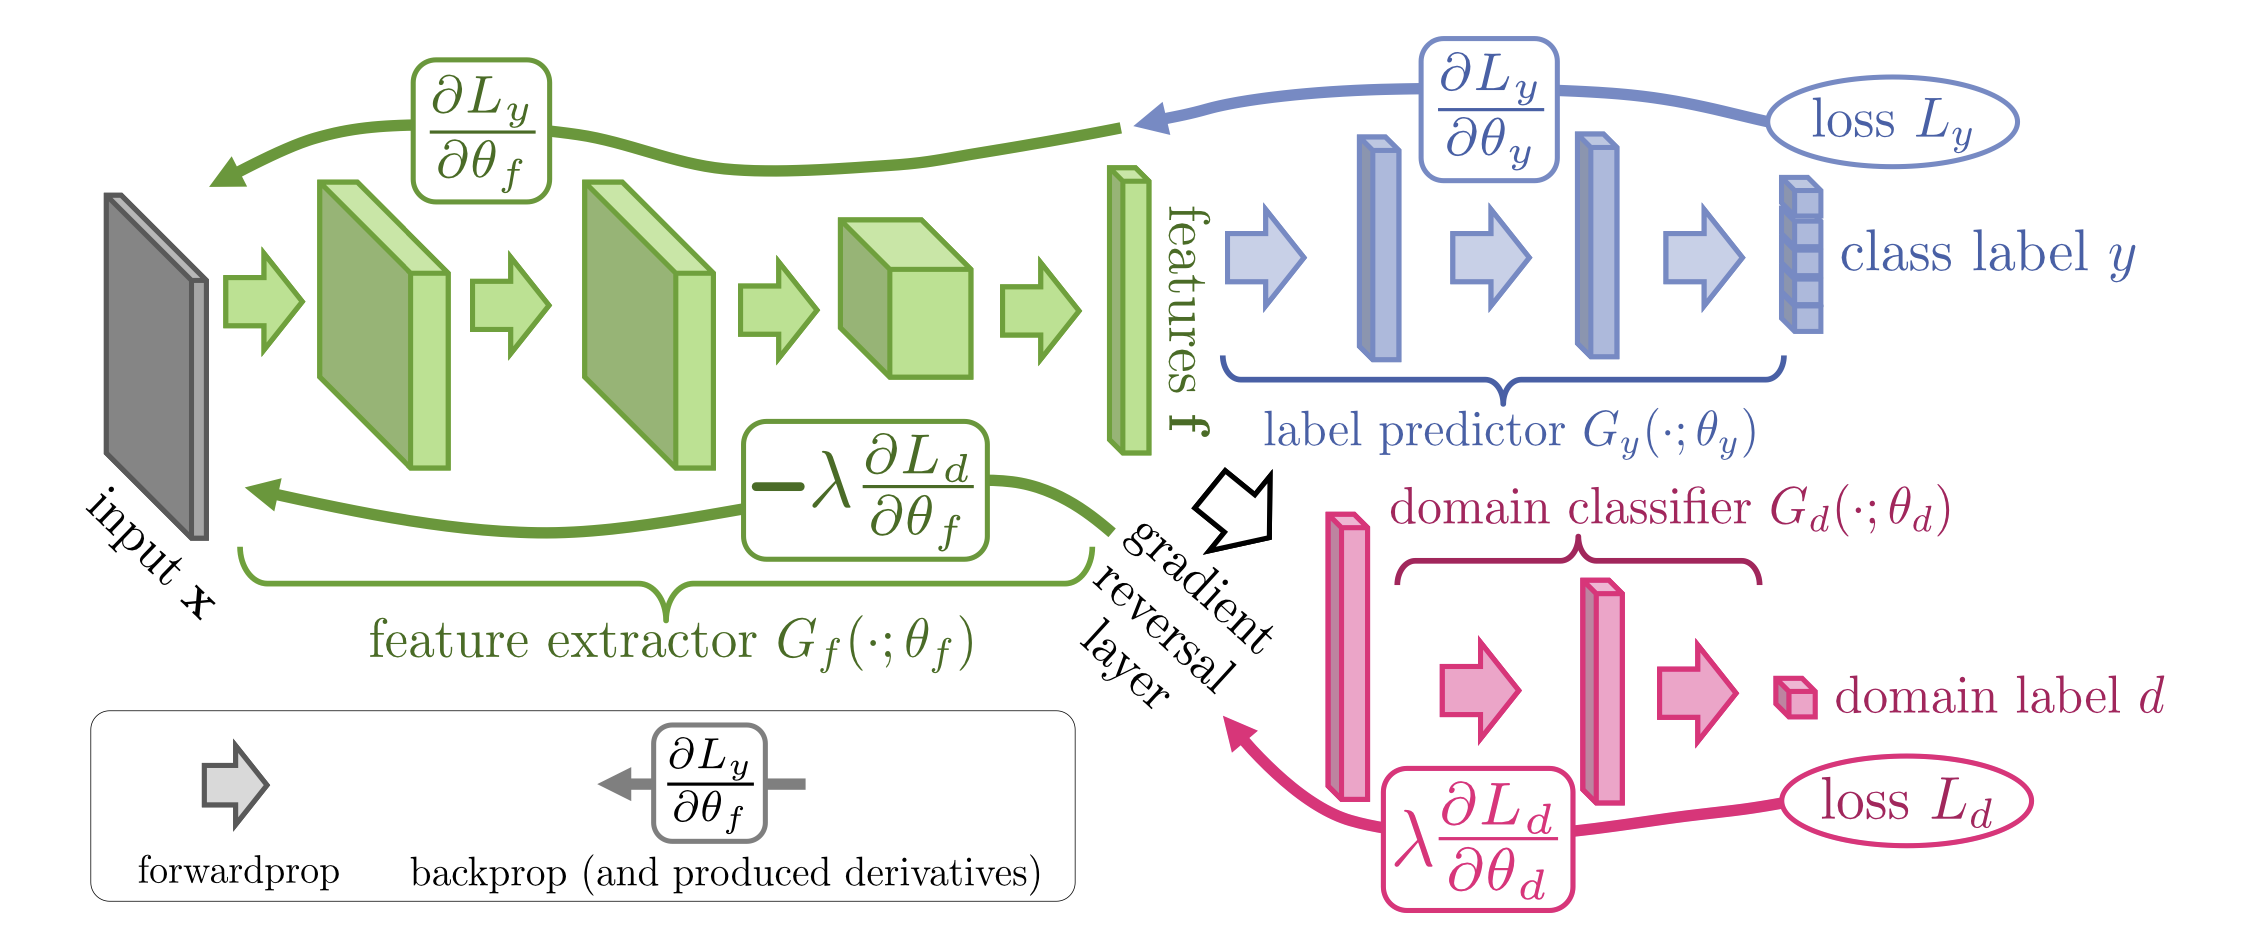

In [4]:
from IPython.display import Image
download_from_url('https://nyu.box.com/shared/static/hinr8xlzb27n5hrrwvc9gd3b1j45a8rh.png', 'dann.png')
Image('dann.png')

In [5]:
import matplotlib.pyplot as plt

def visualize_datasets(source_dataset, target_dataset, n=6):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        img, _ = source_dataset[i]
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title("Source")
        plt.axis('off')

        ax = plt.subplot(2, n, n + i + 1)
        img, _ = target_dataset[i]
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title("Target")
        plt.axis('off')
    plt.show()

In [6]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(32, 48, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
        )
    def forward(self, x):
        return self.network(x)

In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(48 * 4 * 4, 100),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(100, 10),
        )
    def forward(self, x):
        return self.network(x)

class DomainClassifier(nn.Module):
    def __init__(self):
        super(DomainClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(48 * 4 * 4, 100),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(100, 2),
        )
    def forward(self, x, alpha=0):
        return self.network(x)

In [8]:
# Gradient Reversal Layer for DANN
class GradientReversalLayer(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

In [9]:
class DANN(nn.Module):
    def __init__(self):
        super(DANN, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.class_classifier = Classifier()
        self.domain_classifier = DomainClassifier()

    def forward(self, x, alpha=0):
        features = self.feature_extractor(x)
        class_pred = self.class_classifier(features)
        reverse_features = GradientReversalLayer.apply(features, alpha)
        domain_pred = self.domain_classifier(reverse_features)
        return class_pred, domain_pred

In [10]:
def train_dann(model, source_loader, target_loader, optimizer, epochs, alpha):
    model.train()
    for epoch in range(epochs):
        len_dataloader = min(len(source_loader), len(target_loader))
        data_target_iter = iter(target_loader)
        for i, (data_source, label_source) in enumerate(source_loader):
            try:
                data_target, _ = next(data_target_iter)
            except StopIteration:
                data_target_iter = iter(target_loader)  # Reset the target iterator
                data_target, _ = next(data_target_iter)

            data_source, label_source = data_source.to(device), label_source.to(device)
            data_target = data_target.to(device)

            optimizer.zero_grad()
            label_pred, domain_pred = model(data_source, alpha)
            _, domain_pred_target = model(data_target, alpha)

            loss_label = nn.CrossEntropyLoss()(label_pred, label_source)
            loss_domain = nn.CrossEntropyLoss()(domain_pred, torch.zeros(len(data_source), dtype=torch.long).to(device)) + \
                nn.CrossEntropyLoss()(domain_pred_target, torch.ones(len(data_target), dtype=torch.long).to(device))

            loss = loss_label + loss_domain
            loss.backward()
            optimizer.step()

In [11]:
def train_source_only(model, source_loader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for i, (data, target) in enumerate(source_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)  # Corrected here
            loss = nn.CrossEntropyLoss()(output, target)
            loss.backward()
            optimizer.step()

In [12]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            # print(target)
            output = model(data)
            if isinstance(output, tuple):
                output = output[0]  # Use only the class predictions for evaluation
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    return 100. * correct / len(loader.dataset)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 134292810.63it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 22821343.98it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 61546257.39it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7404014.29it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Visualizing datasets...


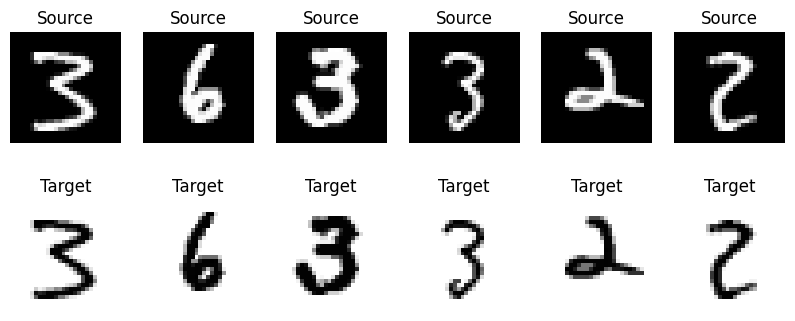

Training DANN model...
Training Source-Only model...
Evaluating DANN on Source Test Set...
Source Domain Accuracy (DANN): 98.75%
Evaluating DANN on Target Test Set...
Target Domain Accuracy (DANN): 48.91%
Evaluating Source-Only on Source Test Set...
Source Domain Accuracy (Source-Only): 98.81%
Evaluating Source-Only on Target Test Set...
Target Domain Accuracy (Source-Only): 35.61%


In [13]:
source_train, source_test, target_train, target_test = load_datasets()
source_loader_train, source_loader_test, target_loader_train, target_loader_test = get_dataloaders(source_train, source_test, target_train, target_test)

print("Visualizing datasets...")
visualize_datasets(source_train, target_train, n=6)

# DANN Model Training and Evaluation
dann_model = DANN().to(device)
optimizer_dann = optim.Adam(dann_model.parameters())
print("Training DANN model...")
train_dann(dann_model, source_loader_train, target_loader_train, optimizer_dann, epochs=5, alpha=0.1)

# Source-Only Model Training and Evaluation
source_only_model = nn.Sequential(FeatureExtractor(), Classifier()).to(device)
optimizer_source_only = optim.Adam(source_only_model.parameters())
print("Training Source-Only model...")
train_source_only(source_only_model, source_loader_train, optimizer_source_only, epochs=5)

# Evaluation on Source and Target Test Sets
print("Evaluating DANN on Source Test Set...")
source_acc_dann = evaluate(dann_model, source_loader_test)
print(f"Source Domain Accuracy (DANN): {source_acc_dann:.2f}%")

print("Evaluating DANN on Target Test Set...")
target_acc_dann = evaluate(dann_model, target_loader_test)
print(f"Target Domain Accuracy (DANN): {target_acc_dann:.2f}%")

print("Evaluating Source-Only on Source Test Set...")
source_acc_source_only = evaluate(source_only_model, source_loader_test)
print(f"Source Domain Accuracy (Source-Only): {source_acc_source_only:.2f}%")

print("Evaluating Source-Only on Target Test Set...")
target_acc_source_only = evaluate(source_only_model, target_loader_test)
print(f"Target Domain Accuracy (Source-Only): {target_acc_source_only:.2f}%")

### Part II: Inverted MNIST with selection bias

We consider four environments here:
1.  Original MNIST with even digits
2.  Original MNIST with odd digits
3. Inverted MNIST with odd digits
4. Inverted MNIST with even digits

We use the first three environments as source data and last environment as target data.

This illustrates our selection bias scenario with MNIST dataset

In [14]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

def load_datasets():
    # Define transformations for even and odd digit images
    transform_standard = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])
    transform_inverted = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        lambda x: 1 - x
    ])

    dataset = datasets.MNIST(root='./data', train=True, download=True)

    def filter_and_transform(data, is_even, invert):
        transform = transform_inverted if invert else transform_standard
        filtered_data = []
        for img, label in data:
            if (label % 2 == 0) == is_even:
                img = transform(img)
                filtered_data.append((img, label))
        return filtered_data

    # Separate the dataset into environments
    data_list = list(dataset)

    env1_data = filter_and_transform(data_list, is_even=True, invert=False)  # Even, MNIST
    env2_data = filter_and_transform(data_list, is_even=False, invert=True)  # Odd, 1 - MNIST
    env3_data = filter_and_transform(data_list, is_even=False, invert=False) # Odd, MNIST
    env4_data = filter_and_transform(data_list, is_even=True, invert=True)   # Even, 1 - MNIST

    # Combine environments 1, 2, and 3 for the source dataset
    combined_source_data = env1_data + env2_data + env3_data
    np.random.shuffle(combined_source_data)
    split_index = int(len(combined_source_data) * 0.8)
    source_train = combined_source_data[:split_index]
    source_test = combined_source_data[split_index:]

    # Environment 4 for the target dataset
    np.random.shuffle(env4_data)
    split_index = int(len(env4_data) * 0.8)
    target_train = env4_data[:split_index]
    target_test = env4_data[split_index:]

    return source_train, source_test, target_train, target_test

def get_dataloaders(source_train, source_test, target_train, target_test, batch_size=64):
    source_loader_train = DataLoader(source_train, batch_size=batch_size, shuffle=True)
    source_loader_test = DataLoader(source_test, batch_size=batch_size, shuffle=True)
    target_loader_train = DataLoader(target_train, batch_size=batch_size, shuffle=True)
    target_loader_test = DataLoader(target_test, batch_size=batch_size, shuffle=True)
    return source_loader_train, source_loader_test, target_loader_train, target_loader_test


Visualizing datasets...


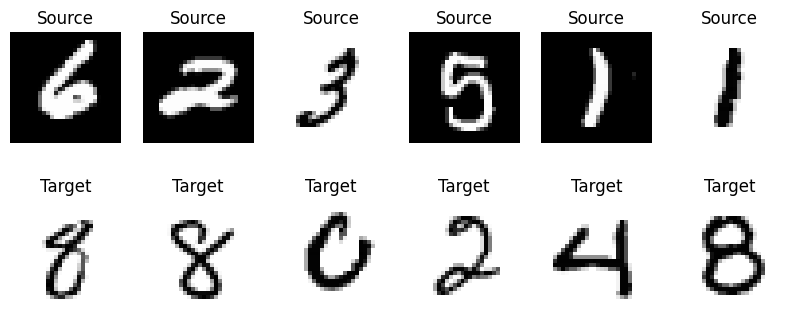

Training DANN model...
Training Source-Only model...
Evaluating DANN on Source Test Set...
Source Domain Accuracy (DANN): 98.96%
Evaluating DANN on Target Test Set...
Target Domain Accuracy (DANN): 18.78%
Evaluating Source-Only on Source Test Set...
Source Domain Accuracy (Source-Only): 99.12%
Evaluating Source-Only on Target Test Set...
Target Domain Accuracy (Source-Only): 3.70%


In [15]:
source_train, source_test, target_train, target_test = load_datasets()
source_loader_train, source_loader_test, target_loader_train, target_loader_test = get_dataloaders(source_train, source_test, target_train, target_test)

print("Visualizing datasets...")
visualize_datasets(source_train, target_train, n=6)

# DANN Model Training and Evaluation
dann_model = DANN().to(device)
optimizer_dann = optim.Adam(dann_model.parameters())
print("Training DANN model...")
train_dann(dann_model, source_loader_train, target_loader_train, optimizer_dann, epochs=5, alpha=0.1)

# Source-Only Model Training and Evaluation
source_only_model = nn.Sequential(FeatureExtractor(), Classifier()).to(device)
optimizer_source_only = optim.Adam(source_only_model.parameters())
print("Training Source-Only model...")
train_source_only(source_only_model, source_loader_train, optimizer_source_only, epochs=5)

# Evaluation on Source and Target Test Sets
print("Evaluating DANN on Source Test Set...")
source_acc_dann = evaluate(dann_model, source_loader_test)
print(f"Source Domain Accuracy (DANN): {source_acc_dann:.2f}%")

print("Evaluating DANN on Target Test Set...")
target_acc_dann = evaluate(dann_model, target_loader_test)
print(f"Target Domain Accuracy (DANN): {target_acc_dann:.2f}%")

print("Evaluating Source-Only on Source Test Set...")
source_acc_source_only = evaluate(source_only_model, source_loader_test)
print(f"Source Domain Accuracy (Source-Only): {source_acc_source_only:.2f}%")

print("Evaluating Source-Only on Target Test Set...")
target_acc_source_only = evaluate(source_only_model, target_loader_test)
print(f"Target Domain Accuracy (Source-Only): {target_acc_source_only:.2f}%")
